# MACD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
currentDir = os.path.dirname(os.path.abspath(__name__))
relativePath = 'ethData/ETHUSDT_2h.csv'
file_path= os.path.join(currentDir, relativePath)
df = pd.read_csv(file_path)
lenDataPoints = len(df)
from untrade.client import Client

In [2]:
def sma(m,n):
    s = 0
    for i in range(1, n+1):
        s += df['close'][m - i]
    s /= n
    return s

def ema(n):
    emaList = [0] * (n - 1)
    sma_ = sum(df['close'][:n]) / n
    emaList.append(sma_)
    k = 2/(n+1)
    for i in range(n, lenDataPoints):
        emaList.append(df['close'][i]*k + emaList[-1]*(1 - k))
    return emaList

In [3]:
ema12List = ema(12)
ema26List = ema(26)
macdList = [0] * 26

for i in range(26, lenDataPoints):
    macdList.append(ema12List[i] - ema26List[i])

signalLine = [0] * (26 + 9 - 1)
signalLine.append(sum(macdList[26:35]) / 9)

k = 2/(9+1)
for i in range(35, lenDataPoints):
    signalLine.append(macdList[i]*k + signalLine[-1]*(1-k))

histogram = [0] * 35
for i in range(35, lenDataPoints):
    histogram.append(macdList[i] - signalLine[i])

In [4]:
buySellList = [0] * lenDataPoints

if histogram[35] > 0:
    buySellList[35] = 1
else:
    buySellList[35] = 2

check = 0

try:
    for i in range(36, lenDataPoints):
        if histogram[i] * histogram[i - 1] < 0:
            if histogram[i] < 0:
                buySellList[i] = -1
                buySellList[i + 1] = 2
                check = 1
            else:
                buySellList[i] = -2
                buySellList[i + 1] = 1
                check = 1
        else:
            if((buySellList[i] == 2 or buySellList[i] == 1) and check):
                check = 0
                continue
            else:
                buySellList[i] = 0
except:
    pass

if histogram[-1] > 0:
    buySellList[-1] = -1
else:
    buySellList[-1] = -2

for i in range(1, lenDataPoints):
    if(buySellList[i] + buySellList[i-1] == 0 and buySellList[i] != 0):
        buySellList[i], buySellList[i-1] = (0, 0)
df['signals'] = buySellList

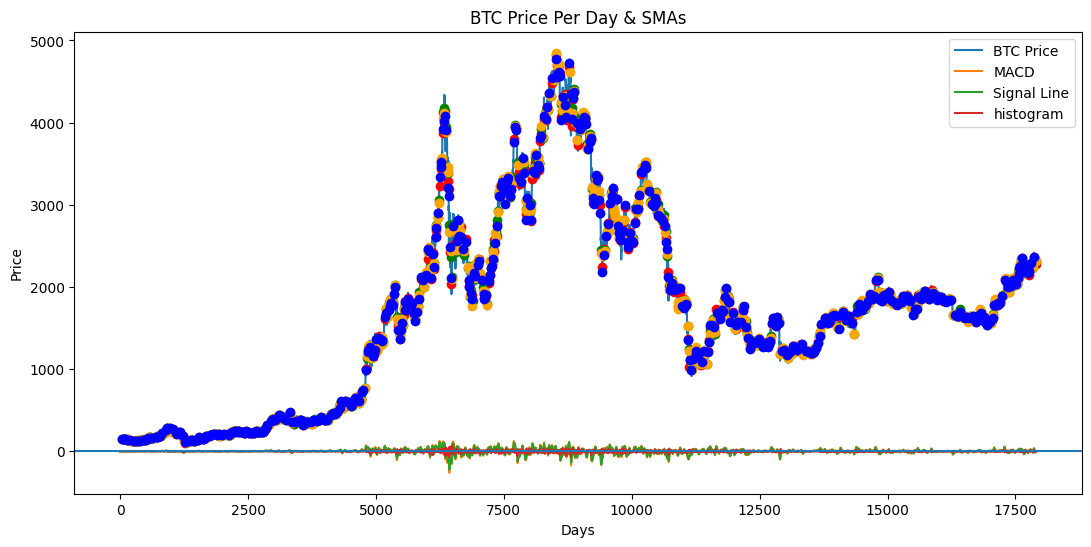

In [5]:
close = df['close'][0:lenDataPoints]
l = list(range(lenDataPoints))
plt.figure(figsize=(13,6))
plt.plot(l, close, label = "BTC Price")
# plt.plot(l, ema12List, label = "12 Day EMA")
# plt.plot(l, ema26List, label = "26 Day EMA")
plt.plot(l, macdList, label = 'MACD')
plt.plot(l, signalLine, label = 'Signal Line')
plt.plot(l, histogram, label = 'histogram')

ls = []
for i in range(lenDataPoints):
    if df['signals'][i] != 0:
        ls.append([i, df["close"][i], df["signals"][i]])

days = [item[0] for item in ls]
values = [item[1] for item in ls]
signal = [item[2] for item in ls]

red_days = [days[i] for i in range(len(signal)) if signal[i] == -1]          #long square-off
red_values = [values[i] for i in range(len(signal)) if signal[i] == -1]      #long square-off
orange_days = [days[i] for i in range(len(signal)) if signal[i] == -2]       #short square-off
orange_values = [values[i] for i in range(len(signal)) if signal[i] == -2]   #short square-off
green_days = [days[i] for i in range(len(signal)) if signal[i] == 1]         #long start
green_values = [values[i] for i in range(len(signal)) if signal[i] == 1]     #long start
blue_days = [days[i] for i in range(len(signal)) if signal[i] == 2]          #short start
blue_values = [values[i] for i in range(len(signal)) if signal[i] == 2]      #short start

plt.plot(red_days, red_values, 'ro')
plt.plot(green_days, green_values, 'go')
plt.plot(orange_days, orange_values, 'o', color='orange')
plt.plot(blue_days, blue_values, 'bo')

plt.axhline(y = 0)
plt.title('BTC Price Per Day & SMAs')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# BackTesting

In [6]:
def perform_backtest(csv_file_path):
    client = Client()
    result = client.backtest(
        jupyter_id="akshatrai",
        file_path=csv_file_path,
        leverage=1,
    )
    return result

In [9]:
df = df.rename(columns={'Unnamed: 0': 'days'})
df.to_csv('signals.csv')
for i in range(len(df)):
    if df.loc[i, 'signals'] == 2 :
        df.loc[i, 'signals'] = -1
    elif df.loc[i, 'signals'] == -2 :
        df.loc[i, 'signals'] = 1
data = df[df['signals'] != 0]
res = data
res.to_csv("processed_data.csv", index=False)

csv_file_path = "processed_data.csv"
backtest_result = perform_backtest(csv_file_path)
last_value = None
for value in backtest_result:
    last_value = value
    print(value)

data: {
  "jupyter_id": "akshatrai",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2019-12-03 22:00:00",
      "Total Trades": 1122,
      "Leverage Applied": 1.0,
      "Winning Trades": 408,
      "Losing Trades": 714,
      "No. of Long Trades": 559,
      "No. of Short Trades": 563,
      "Benchmark Return(%)": 1467.443916,
      "Benchmark Return(on $1000)": 14674.439157,
      "Win Rate": 36.363636,
      "Winning Streak": 7,
      "Losing Streak": 12,
      "Gross Profit": 4313.722412,
      "Net Profit": 2630.722412,
      "Average Profit": 2.344672,
      "Maximum Drawdown(%)": 32.902231,
      "Average Drawdown(%)": 7.675703,
      "Largest Win": 329.168069,
      "Average Win": 46.353065,
      "Largest Loss": -188.668209,
      "Average Loss": -22.802981,
      "Maximum Holding Time": "4 days 19:59:59",
      "Average Holding Time": "1 days 5:34:7",
      "Maximum Adverse Excursion": 20.370089,
      "Ave

# Crocodile Strategy

In [10]:
currentDir = os.path.dirname(os.path.abspath(__name__))
relativePath = 'ethData/ETHUSDT_30m.csv'
relativePath = 'ethData/ETHUSDT_1d.csv'
file_path= os.path.join(currentDir, relativePath)
df = pd.read_csv(file_path)
lenDataPoints = len(df)

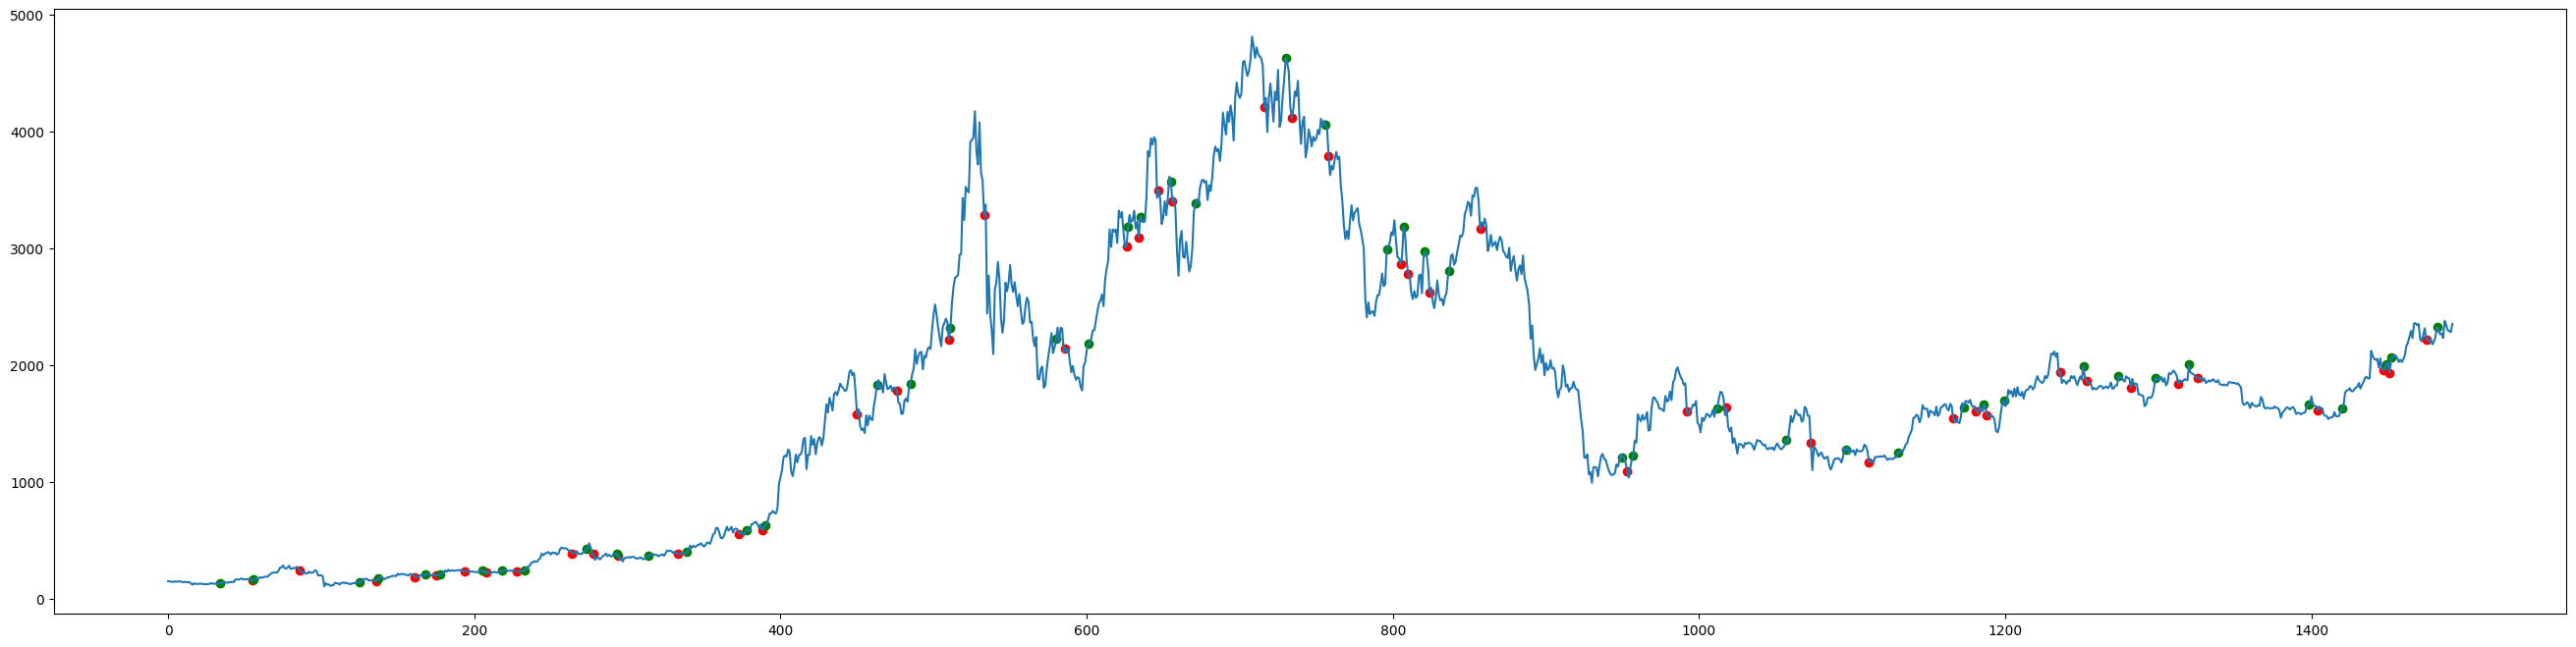

In [15]:
blue = ema(13)
red = ema(8)
green = ema(5)

check1 = 0
check2 = 0

signal = [0] * 13
for i in range(13, lenDataPoints):
    if blue[i] < red[i] < green[i]:
        if check1 == 0:
            signal.append(1)
            check1 = 1
        else:
            signal.append(0)
    else:
        if check1 == 1:
            signal.append(-1)
            check1 = 0
        else:
            signal.append(0)

df['signals'] = signal

plt.figure(figsize=(33,8))
l = list(range(lenDataPoints))
red_days = [i for i in range(lenDataPoints) if signal[i] == -1]          #long square-off
red_values = [df['close'][i] for i in range(lenDataPoints) if signal[i] == -1]      #long square-off
green_days = [i for i in range(lenDataPoints) if signal[i] == 1]         #long start
green_values = [df['close'][i] for i in range(lenDataPoints) if signal[i] == 1]     #long start
plt.plot(red_days, red_values, 'ro')
plt.plot(green_days, green_values, 'go')
plt.plot(df['close'])
plt.show()

In [12]:
df = df.rename(columns={'Unnamed: 0': 'days'})
df.to_csv('signals.csv')
for i in range(len(df)):
    if df.loc[i, 'signals'] == 2 :
        df.loc[i, 'signals'] = -1
    elif df.loc[i, 'signals'] == -2 :
        df.loc[i, 'signals'] = 1
data = df[df['signals'] != 0]
res = data
res.to_csv("processed_data.csv", index=False)

csv_file_path = "processed_data.csv"
backtest_result = perform_backtest(csv_file_path)
last_value = None
for value in backtest_result:
    print(value)
    last_value = value

data: {
  "jupyter_id": "akshatrai",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2020-01-04 00:00:00",
      "Total Trades": 47,
      "Leverage Applied": 1.0,
      "Winning Trades": 20,
      "Losing Trades": 27,
      "No. of Long Trades": 47,
      "No. of Short Trades": 0,
      "Benchmark Return(%)": 1634.404354,
      "Benchmark Return(on $1000)": 16344.043537,
      "Win Rate": 42.553191,
      "Winning Streak": 4,
      "Losing Streak": 5,
      "Gross Profit": 4448.325358,
      "Net Profit": 4377.825358,
      "Average Profit": 93.14522,
      "Maximum Drawdown(%)": 8.863356,
      "Average Drawdown(%)": 2.084023,
      "Largest Win": 1517.314375,
      "Average Win": 292.146812,
      "Largest Loss": -128.794086,
      "Average Loss": -54.263366,
      "Maximum Holding Time": "60 days 0:0:0",
      "Average Holding Time": "15 days 10:43:24",
      "Maximum Adverse Excursion": 26.845672,
      "Average A